In [10]:
import os
from qdrant_client import QdrantClient
from openai import OpenAI
from dotenv import load_dotenv
from qdrant_client.http import models

# Understanding RAG

There are 3 steps in any RAG system:
1. Retrieval
2. Augmentation
3. Generation

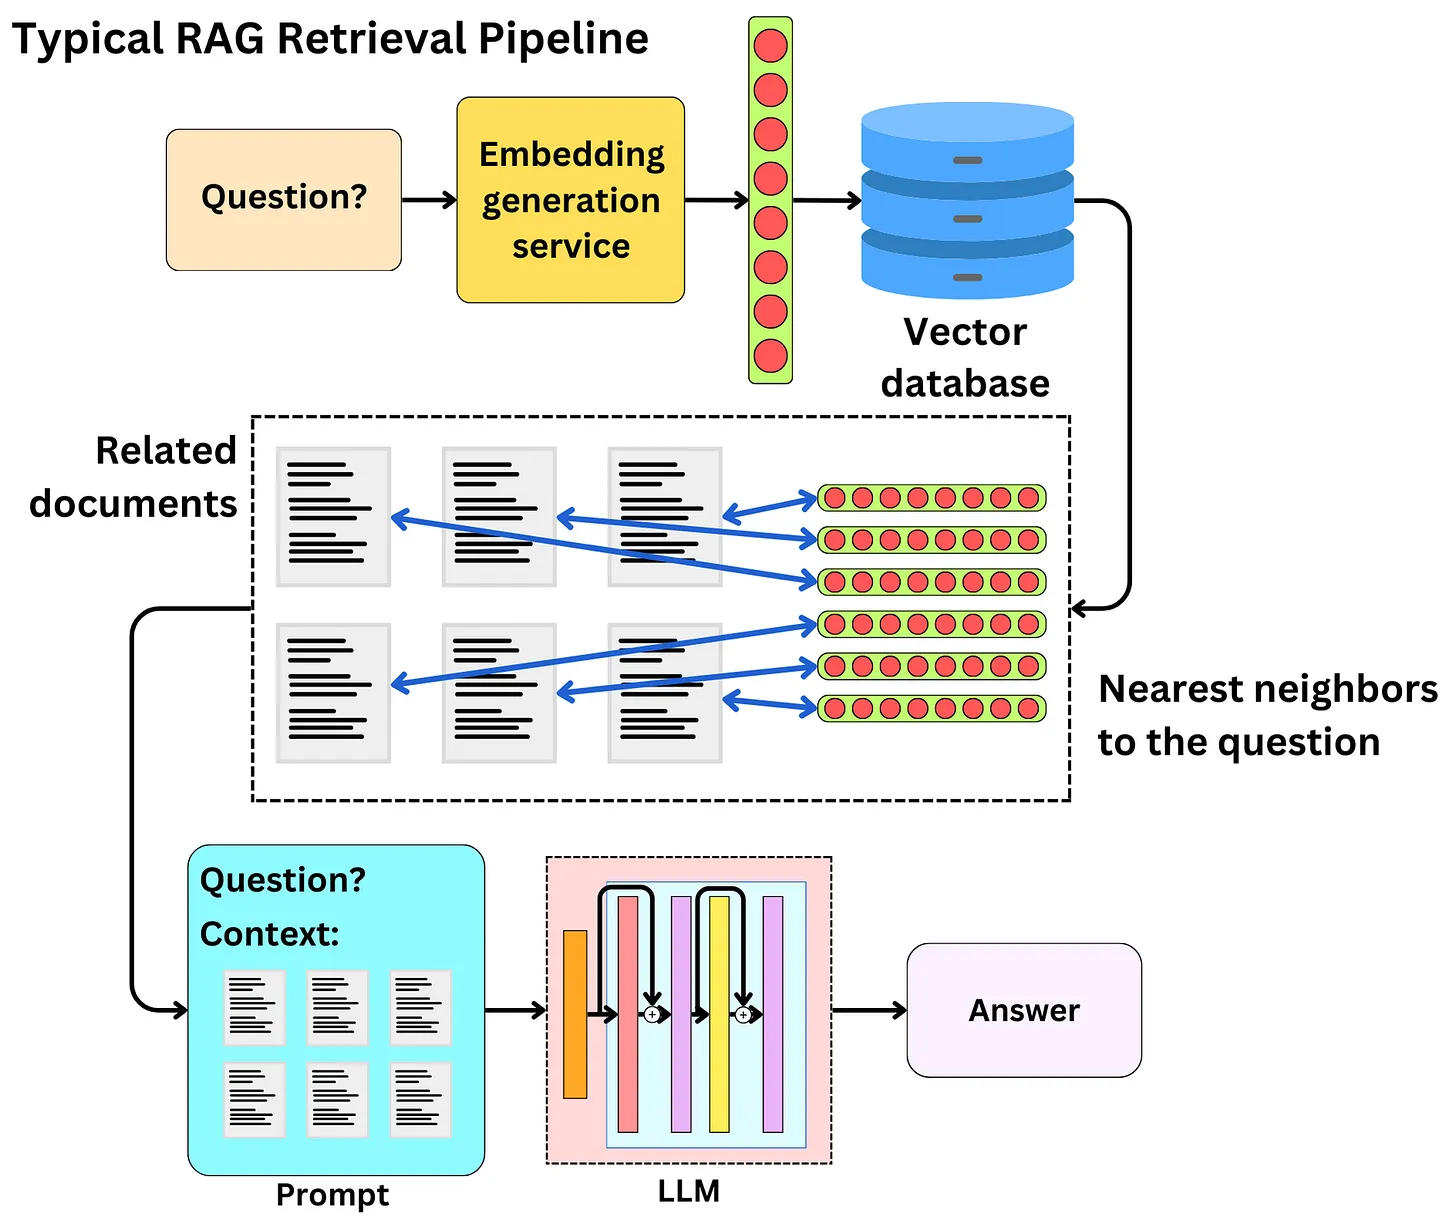

Source: https://newsletter.theaiedge.io/

These are the steps you see in the diagram above:

1. Indexing Stage: 
    - Collect knowledge base articles (SOPs etc)
    - Split the article into smaller chunks
    - Compute embedding for each chunk
    - Store the chunks and their embeddings in a Vector database
2. Querying Stage:
    - User asks a query Q
    - Search the Vector data for top-K chunks similar to Q (based on similarity between embedding vectors) (RETRIEVAL)
    - Create a prompt containing user query Q and top-K chunks retrieved (AUGMENTATION)
    - Use a LLM to generate a response for the above prompt (GENERATION)


# Implementation

In [20]:
university_info = """
The University of Washington, founded in 1861 in Seattle, is a public research university
with over 45,000 students across three campuses in Seattle, Tacoma, and Bothell.
As the flagship institution of the six public universities in Washington state,
UW encompasses over 500 buildings and 20 million square feet of space,
including one of the largest library systems in the world. The university offers more than 180 majors and 
has a strong emphasis on research, innovation, and entrepreneurship. It is known for its programs in areas 
like Medicine, Engineering, Business, and Computer Science. The university's faculty includes numerous 
Nobel laureates, Pulitzer Prize winners, and Fulbright scholars. The campus is known for its iconic 
Cherry Blossom trees that bloom every spring. The university's sports teams, known as the Huskies, 
participate in the NCAA Division I Pac-12 Conference.
"""

In [21]:
load_dotenv()
openai_client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
def create_embedding(text):
    return openai_client.embeddings.create(input = [text], model="text-embedding-3-small",dimensions=1536).data[0].embedding

### Chunking (Split the text into smaller parts)

In [22]:
def split_into_chunks(text, chunk_size=200):
    """
    Split the text into chunks of a specified size.
    """
    chunks = [text[i:i+chunk_size] for i in range(0, len(text), chunk_size)]
    return chunks

### Ingestion to Vector Store

In [24]:
vector_store = QdrantClient(":memory:")
vector_store.recreate_collection('sample_collection',vectors_config=models.VectorParams(size=1536, distance=models.Distance.COSINE))
university_info_chunks = split_into_chunks(university_info)
university_info_embeddings = [create_embedding(chunk) for chunk in university_info_chunks]
points = []
for idx, (text, embedding) in enumerate(zip(university_info_chunks,university_info_embeddings)):
    points.append(models.PointStruct(
        id=idx,  
        vector=embedding,  
        payload={'text': text}  
    ))
vector_store.upload_points(collection_name='sample_collection', points=points)

### Retrieval Pipeline

In [31]:
class RAG_from_scratch:
    def retrieve(self, query: str) -> list:
        """
        Retrieve relevant text from vector store.
        """
        embedding_text = create_embedding(query)
        results = vector_store.search(
        collection_name='sample_collection',
        query_vector=embedding_text,
        limit=2
    )
        return "\n".join([result.payload['text'] for result in results])

    def generate_completion(self, query: str, context_str: list) -> str:
        """
        Generate answer from context.
        """
        completion = openai_client.chat.completions.create(
        model="gpt-3.5-turbo",
        temperature=0,
        messages=
        [
            {"role": "user",
            "content": 
            f"We have provided context information below. \n"
            f"---------------------\n"
            f"{context_str}"
            f"\n---------------------\n"
            f"Given this information, please answer the question: {query}"
            }
        ]
        ).choices[0].message.content
        return completion

    def query(self, query: str) -> str:
        context_str = self.retrieve(query)
        completion = self.generate_completion(query, context_str)
        return completion

rag = RAG_from_scratch()

In [32]:
rag.query("When was the University of Washington founded?")

'The University of Washington was founded in 1861.'